C:\Users\hp\AppData\Local\Temp\ipykernel_12608\95866479.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings["price_per_person"] = (
C:\Users\hp\AppData\Local\Temp\ipykernel_12608\95866479.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings["host_experience_years"] = (


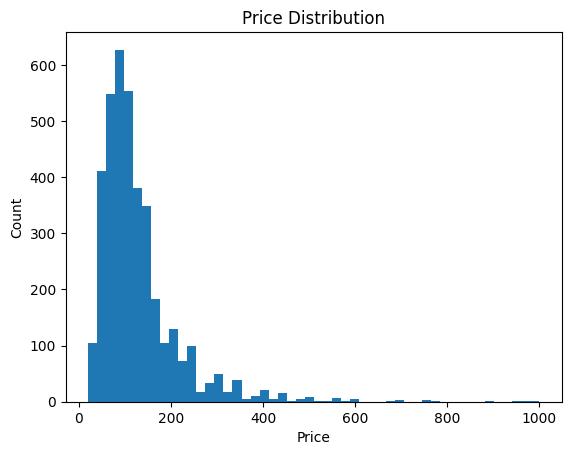

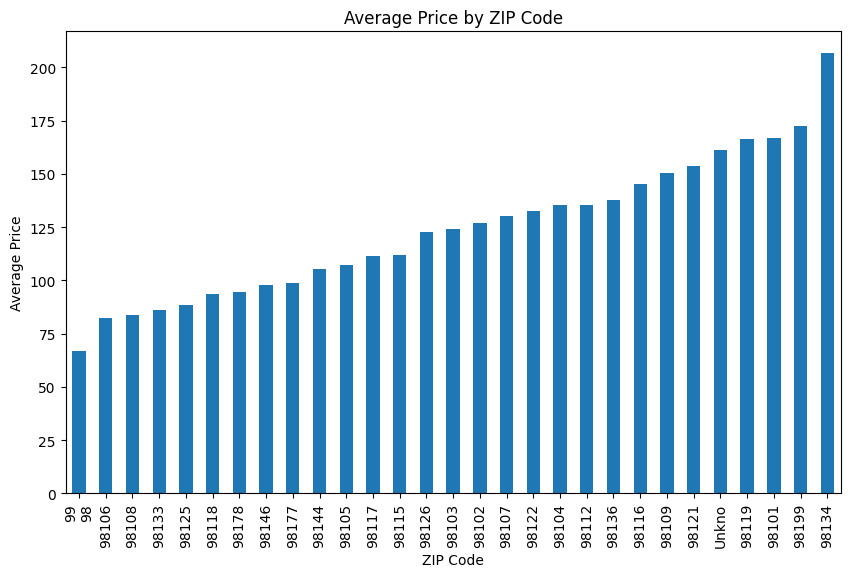

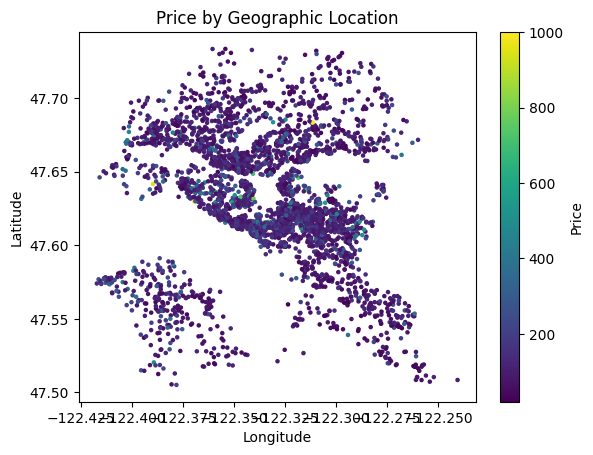

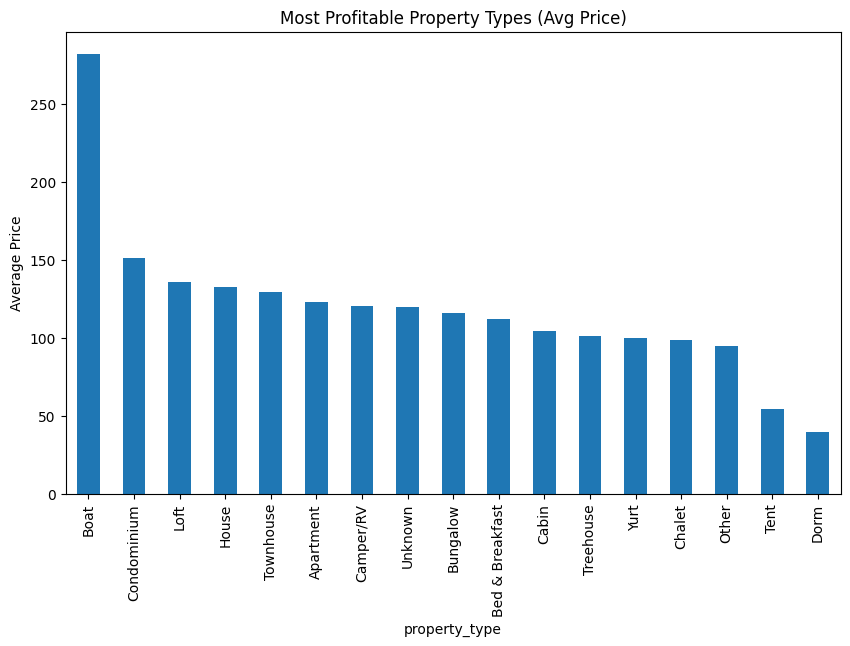

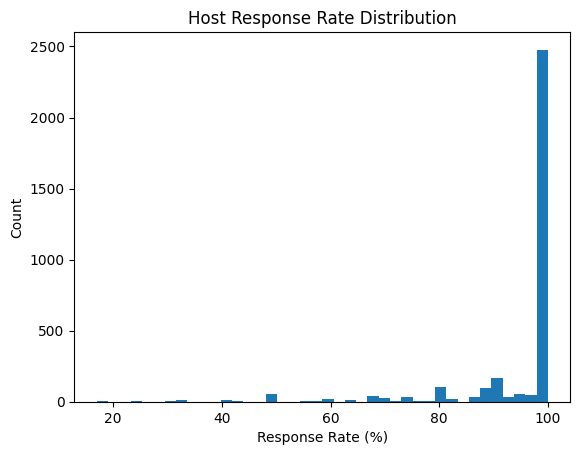

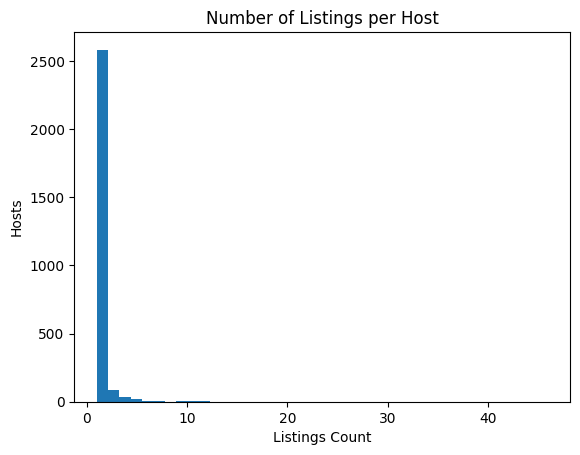

C:\Users\hp\AppData\Local\Temp\ipykernel_12608\95866479.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings["occupancy"] = 365 - listings["availability_365"]


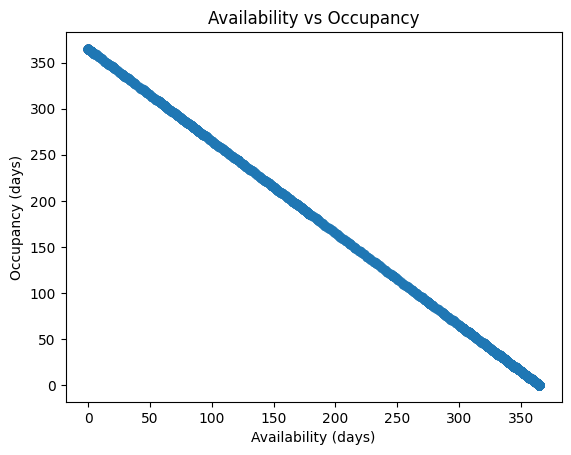

Business analysis completed successfully.
✔ All cleaned files exported successfully!


In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# IMPORTING THE CSV
listings = pd.read_csv("listings.csv")
calendar = pd.read_csv("calendar.csv")
reviews = pd.read_csv("reviews.csv")

# HANDLE MISSING VALUES

# Numeric → fill with median
num_cols = listings.select_dtypes(include=[np.number]).columns
listings[num_cols] = listings[num_cols].fillna(listings[num_cols].median())

# Text columns → fill with "Unknown"
text_cols = listings.select_dtypes(include=['object']).columns
listings[text_cols] = listings[text_cols].fillna("Unknown")

# Calendar missing price → fill with "$0"
calendar['price'] = calendar['price'].fillna("$0")

# CLEAN PRICE COLUMNS

def clean_price(x):
    x = str(x).replace('$', '').replace(',', '')
    return float(x) if x.strip() != "" else 0

calendar['price'] = calendar['price'].apply(clean_price)

if 'price' in listings.columns:
    listings['price'] = listings['price'].apply(clean_price)

# NORMALIZE PRICE

if 'price' in listings.columns:
    min_val = listings['price'].min()
    max_val = listings['price'].max()
    listings['price_normalized'] = (listings['price'] - min_val) / (max_val - min_val)

# CONVERT DATE COLUMNS

calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped']

for col in date_cols:
    if col in listings.columns:
        listings[col] = pd.to_datetime(listings[col], errors='coerce')

# MAP CATEGORICAL VALUES

if 'available' in calendar.columns:
    calendar['available'] = calendar['available'].map({'t': 1, 'f': 0})

# Room type mapping
if 'room_type' in listings.columns:
    room_map = {
        'Entire home/apt': 1,
        'Private room': 2,
        'Shared room': 3,
        'Hotel room': 4
    }
    listings['room_type_code'] = listings['room_type'].map(room_map)

# EXTRACT AMENITIES

if 'amenities' in listings.columns:
    listings['amenities_list'] = (
        listings['amenities']
        .str.replace('{', '', regex=False)
        .str.replace('}', '', regex=False)
        .str.replace('"', '', regex=False)
        .str.split(',')
    )

    common_amenities = ['Wifi', 'TV', 'Heating', 'Kitchen', 'Washer']

    for amenity in common_amenities:
        listings[f'amenity_{amenity.lower()}'] = listings['amenities_list'].apply(
            lambda x: 1 if amenity in [i.strip() for i in x] else 0
        )

# FEATURE ENGINEERING

# Price per person
if "accommodates" in listings.columns and "price" in listings.columns:
    listings["price_per_person"] = (
        listings["price"] / listings["accommodates"].replace(0, np.nan)
    )

# Host experience
if "host_since" in listings.columns:
    listings["host_experience_years"] = (
        pd.Timestamp.today().year - listings["host_since"].dt.year
    )

# Review sentiment (length)
if "comments" in reviews.columns:
    reviews["review_rate_sentiment"] = (
        reviews["comments"].fillna("").apply(lambda x: len(str(x)))
    )

# Calendar seasonality
calendar["month"] = calendar["date"].dt.month
calendar["day_of_week"] = calendar["date"].dt.dayofweek
calendar["is_weekend"] = calendar["day_of_week"].isin([5, 6]).astype(int)

# BUSINESS ANALYSIS

# PRICE DISTRIBUTION
plt.hist(listings["price"], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# PRICE HEATMAP BY ZIP CODE
if "zipcode" in listings.columns:
    listings["zipcode"] = listings["zipcode"].astype(str).str[:5]

    zip_price = listings.groupby("zipcode")["price"].mean().sort_values()

    plt.figure(figsize=(10, 6))
    zip_price.plot(kind="bar")
    plt.title("Average Price by ZIP Code")
    plt.xlabel("ZIP Code")
    plt.ylabel("Average Price")
    plt.show()

# IMPACT OF LOCATION ON PRICE
if "latitude" in listings.columns and "longitude" in listings.columns:
    plt.scatter(listings["longitude"], listings["latitude"], s=5, c=listings["price"])
    plt.title("Price by Geographic Location")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Price")
    plt.show()

# MOST PROFITABLE PROPERTY TYPES
if "property_type" in listings.columns:
    profitability = (
        listings.groupby("property_type")["price"].mean().sort_values(ascending=False)
    )

    profitability.plot(kind="bar", figsize=(10, 6))
    plt.title("Most Profitable Property Types (Avg Price)")
    plt.ylabel("Average Price")
    plt.show()

# HOST PERFORMANCE INDICATORS

# FIXED RESPONSE RATE ISSUE
if "host_response_rate" in listings.columns:
    listings["host_response_rate"] = (
        listings["host_response_rate"]
        .astype(str)
        .str.replace("%", "", regex=False)
        .replace(["nan", "NaN", "None", "Unknown", ""], np.nan)
    )

    listings["host_response_rate"] = pd.to_numeric(
        listings["host_response_rate"], errors="coerce"
    )

    plt.hist(listings["host_response_rate"], bins=40)
    plt.title("Host Response Rate Distribution")
    plt.xlabel("Response Rate (%)")
    plt.ylabel("Count")
    plt.show()

# HOST LISTING COUNT
if "host_id" in listings.columns:
    host_listings_count = listings["host_id"].value_counts()

    plt.hist(host_listings_count, bins=40)
    plt.title("Number of Listings per Host")
    plt.xlabel("Listings Count")
    plt.ylabel("Hosts")
    plt.show()

# AVAILABILITY VS OCCUPANCY
if "availability_365" in listings.columns:
    listings["occupancy"] = 365 - listings["availability_365"]

    plt.scatter(listings["availability_365"], listings["occupancy"], alpha=0.4)
    plt.title("Availability vs Occupancy")
    plt.xlabel("Availability (days)")
    plt.ylabel("Occupancy (days)")
    plt.show()

print("Business analysis completed successfully.")

# EXPORT CLEANED FILES

listings_cleaned = listings.copy()
reviews_cleaned = reviews.copy()
calendar_cleaned = calendar.copy()

listings_cleaned.to_csv("cleaned_listings.csv", index=False)
reviews_cleaned.to_csv("cleaned_reviews.csv", index=False)
calendar_cleaned.to_csv("cleaned_calendar.csv", index=False)

print("✔ All cleaned files exported successfully!")

